# TensorFlow

참고 : TensorFlow Machine Learning Cookbook

In [1]:
import tensorflow as tf
sess = tf.Session()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np
import matplotlib.pyplot as plt

### 다중 분류 SVM 구현

In [3]:
# 데이터 로드
from sklearn import datasets
iris = datasets.load_iris()

x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals1 = np.array([1 if y==0 else -1 for y in iris.target])
y_vals2 = np.array([1 if y==1 else -1 for y in iris.target])
y_vals3 = np.array([1 if y==2 else -1 for y in iris.target])
y_vals = np.array([y_vals1, y_vals2, y_vals3])

class1_x = [x[0] for i, x in enumerate(x_vals) if iris.target[i]==0]
class1_y = [x[1] for i, x in enumerate(x_vals) if iris.target[i]==0]
class2_x = [x[0] for i, x in enumerate(x_vals) if iris.target[i]==1]
class2_y = [x[1] for i, x in enumerate(x_vals) if iris.target[i]==1]
class3_x = [x[0] for i, x in enumerate(x_vals) if iris.target[i]==2]
class3_y = [x[1] for i, x in enumerate(x_vals) if iris.target[i]==2]


# 일괄 작업 크기 선언
batch_size = 50


# 플레이스홀더 및 변수 선언
x_data = tf.placeholder(shape=[None,2], dtype=tf.float32)
y_target = tf.placeholder(shape=[3,None], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None,2], dtype=tf.float32)
b = tf.Variable(tf.random_normal(shape=[3,batch_size]))


# 가우시안 커널 선언
gamma = tf.constant(-10.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist,[-1,1])
sq_dists = tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))


# 행렬 곱셈을 일괄적으로 하는 함수
def reshape_matmul(mat):
    v1 = tf.expand_dims(mat,1)
    v2 = tf.reshape(v1, [3, batch_size, 1])
    return(tf.matmul(v2,v1))


# 비용 함수 생성
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = reshape_matmul(y_target)

second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)), [1,2])
loss = tf.reduce_sum(tf.negative(tf.subtract(first_term, second_term)))


# 예측 커널 생성
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1), [-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1), [-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))),
                      tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(y_target, b), pred_kernel)
prediction = tf.argmax(prediction_output - tf.expand_dims(tf.reduce_mean(prediction_output, 1), 1), 0)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_target,0)), tf.float32))


# 최적화 함수 선언
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)


# 변수 초기화
init = tf.global_variables_initializer()
sess.run(init)


# 학습
loss_vec = []
batch_acc = []

for i in range(100):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = y_vals[:, rand_index]
    sess.run(train_step, feed_dict={x_data:rand_x, y_target:rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data:rand_x, y_target:rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data:rand_x, y_target:rand_y, prediction_grid:rand_x})
    batch_acc.append(acc_temp)
    
    if (i+1) % 25 == 0:
        print('Step #{}'.format(str(i+1)))
        print('Loss = {}'.format(str(temp_loss)))

Step #25
Loss = -322.6143
Step #50
Loss = -660.114
Step #75
Loss = -997.6138
Step #100
Loss = -1335.1136


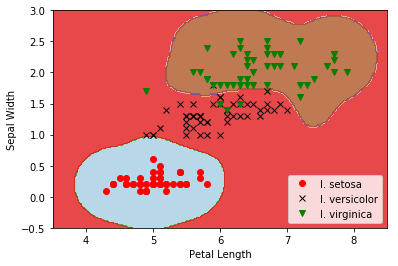

In [4]:
# 예측
x_min, x_max = x_vals[:,0].min() - 1, x_vals[:,0].max() + 1
y_min, y_max = x_vals[:,1].min() - 1, x_vals[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min,y_max, 0.02))

grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_predictions = sess.run(prediction, feed_dict={x_data:rand_x,
                                                  y_target:rand_y,
                                                  prediction_grid:grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)


# 예측 결과
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='I. setosa')
plt.plot(class2_x, class2_y,' kx', label='I. versicolor')
plt.plot(class3_x, class3_y, 'gv', label='I. virginica')

plt.xlabel('Petal Length')
plt.ylabel('Sepal Width')
plt.legend(loc='lower right')
plt.ylim([-0.5, 3.0])
plt.xlim([3.5, 8.5])
plt.show()

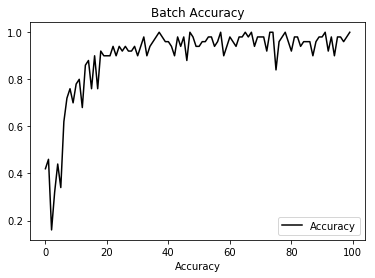

In [5]:
# 일괄 작업 정확도
plt.plot(batch_acc, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

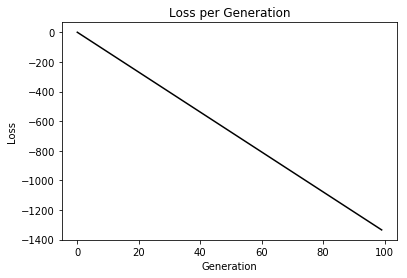

In [6]:
# 비용 함수 값
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()